In [68]:
import requests
import pandas as pd
import csv
from io import StringIO
import numpy as np
import scipy
import matplotlib.pyplot as plt

element = 'ag'.lower() #소문자로 작성 추천

def getf(element):

    # Send an HTTP GET request to the URL
    response = requests.get('https://henke.lbl.gov/optical_constants/sf/'+element+'.nff')
    if response.status_code == 200:
        content = StringIO(response.text)
        df = pd.read_csv(content, sep='\t')
    else: print("에러")

    df = df.reset_index()
    df = df.drop('f2',axis = 1)
    df.columns = ['E','f1','f2']
    df = df.assign(newf1=math.nan)
#     df.plot(kind = 'scatter',x='E', y='f1')
#     plt.show()
    return df

df = getf(element)

f=open('period table.csv','r')
Pt = csv.reader(f)
for i in Pt:
    if element == i[0].lower():
        element_number = int(i[1])
f.close()


# df 

#kk함수
# 2/pi()*

In [69]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import math
from numba import njit
from numba.typed import List
import time

#속도 높이기 위해 함수 형식으로
def get_KK_f1(list_E,list_f2,lenth):
    
    def g(x,y):
        if x==y:
            return (x+y)*math.log(x+y)
        elif y == math.inf:
            return 0
        else:
            return (x+y)*math.log(x+y)+(x-y)*math.log(abs(x-y))

    # 리핏 메뉴얼에 적혀있는 방법인데 내가 수정(리핏틀림!)
    def kk_linearfit(w,w0,w1,w2):
        return 1/math.pi*(g(w0,w)/(w1-w0)-(w2-w0)*g(w1,w)/(w1-w0)/(w2-w1)+g(w2,w)/(w2-w1))

    # 초반 외삽 (x^2으로 피팅)
    def kk_expol_front(w,w1,w2):
        def f(w,w1,w2):
            if -1*w == w1:
                return 0
            else:
                return (w**2/w1**2-(w2+w)/(w2-w1))*math.log(abs(w1+w))
        return 1/math.pi*(-1-2*w**2/w1**2*math.log(w)+g(w2,w)/(w2-w1)+f(w,w1,w2)+f(-1*w,w1,w2))

    # 후반 외삽 (x^-2으로 피팅) 중요 틀린 것 같다. 다시 계산해보자. x값에 대해 편하게 바꿀 수 있는 함수로 만들고 싶은 바람이 있다.
    def kk_expol_end2(w,w0,w1):
        def f(w,w0,w1):
            if -1*w == w1:
                return 0
            else:
                return (w1/w**2-(w0+w)/(w1-w0))*math.log(abs(w1+w))
        return 1/math.pi*(2-2*w1/w**2*math.log(w1)+g(w0,w)/(w1-w0)+f(w,w0,w1)+f(-1*w,w0,w1))
    
    # 후반 외삽 (x^-1으로 피팅) 
    def kk_expol_end1(w,w0,w1):
        def f(w,w0,w1):
            if -1*w == w1:
                return 0
            else:
                return (w1/w-(w0+w)/(w1-w0))*math.log(abs(w1+w))
        return 1/math.pi*(2+g(w0,w)/(w1-w0)+f(w,w0,w1)+f(-1*w,w0,w1))
    
    list_newf1 = []
    lenth = len(df)
    lastpoint = lenth - 1
#     low_expol_a = list_f2[0]/list_E[0]**2
#     high_expol_a = list_f2[lastpoint]*list_E[lastpoint]
    for i in range(lenth):
        w_n=list_E[i]
        kk_sum = 0
        for j in range(lenth):
            if j==0:
                x1 = list_E[0]; x2 = list_E[1]; y = list_f2[0]
                kk_sum += y * kk_expol_front(w_n,x1,x2)
            elif j==lastpoint:
                x0 = list_E[j-1]; x1 = list_E[j]; y = list_f2[j]
                kk_sum += y * kk_expol_end1(w_n,x0,x1)
            else:
                x0 = list_E[j-1]; x1 = list_E[j]; x2 =list_E[j+1]; y = list_f2[j]
                kk_sum += y * kk_linearfit(w_n,x0,x1,x2)
        list_newf1.append(-1*kk_sum)
    diff = df.loc[300,'f1']-list_newf1[300]
    list_newf1 = [list_newf1[i] + diff for i in range(lenth)]
    return list_newf1

start = time.time()
# list_E = List(); list_f2 = List()
# [list_E.append(x) for x in ]; [list_f2.append(x) for x in ]
df['newf1'] = get_KK_f1(df['E'].tolist(),df['f2'].tolist(),len(df))
end = time.time()
print(f"Elapsed Time (pure python) = {end - start}")
pd.set_option('display.max_rows', None)
df


Elapsed Time (pure python) = 0.48119115829467773


,E,f1,f2,newf1
0,10.0000,-9999.000000,1.185660,-3.034345
1,10.1617,-9999.000000,1.229410,-3.091351
2,10.3261,-9999.000000,1.274780,-3.150512
3,10.4931,-9999.000000,1.321820,-3.216964
4,10.6628,-9999.000000,1.382150,-3.289201
5,10.8353,-9999.000000,1.455410,-3.358153
6,11.0106,-9999.000000,1.532560,-3.422047
7,11.1886,-9999.000000,1.613790,-3.483519
8,11.3696,-9999.000000,1.699330,-3.542648
9,11.5535,-9999.000000,1.787550,-3.600158


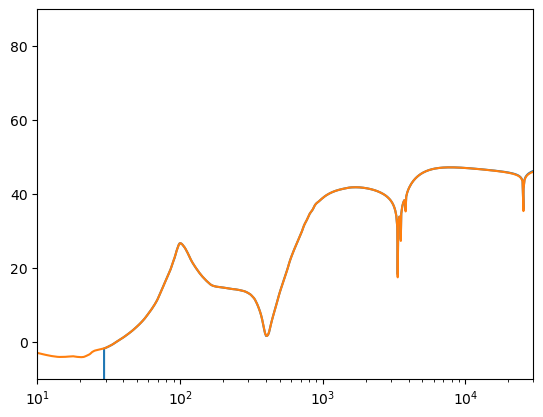

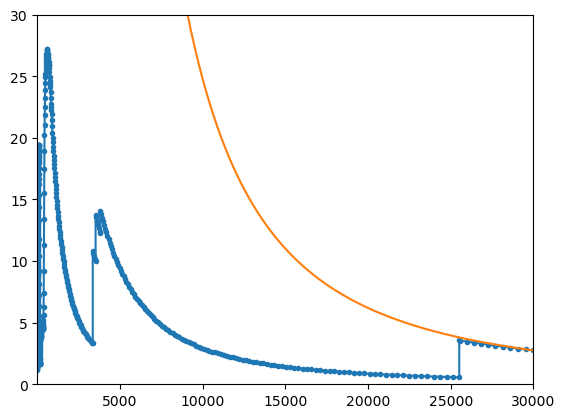

In [70]:

# df.plot(kind = 'scatter',x='E', y='f1')
# plt.xlim([10, 30000])
# plt.xscale('symlog')
# plt.ylim([-10, 40])
# plt.show()
# df.plot(kind = 'scatter',x='E', y='newf1')
# plt.xscale('symlog')
# plt.xlim([10, 30000])
# plt.ylim([-10, 40])
# plt.show()

plt.plot(df['E'].tolist(), df['f1'].tolist(),df['E'].tolist(), df['newf1'].tolist())
plt.xscale('log')
plt.xlim([10, 30000])
plt.ylim([-10, 90])
plt.show()
plt.plot(df['E'].tolist(), df['f2'].tolist(),marker = '.')
x = np.linspace(10, 40000,10000) 
lastpoint = len(df) - 1
plt.plot(x,(df.loc[lastpoint,'f2'])*df.loc[lastpoint,'E']**2*x**-2)#1.7이 피팅이 기가 막히게 되는데 당최 왜그런지 이유는 모르겠다.
# plt.xscale('log')
plt.xlim([10, 30000])
plt.ylim([0, 30])
plt.show()



In [75]:
import cmath
for i in range(len(df)):
    f=complex(df.loc[i,'f1'],-1*df.loc[i,'f2'])
#     a=2.53707/math.pi*1e2/df.loc[i,'E']**2
    a=4.41e-2/math.pi*4.39e3/df.loc[i,'E']**2
    af = a*f
    e=1-af
    N=cmath.sqrt(e)
    R=abs((1-N)/(1+N)).real
    df.loc[i,'R'] = R**2
#     a = 3.2688*math.pi/(8.065*df.loc[i,'E'])**2*1e10
#     a = a*1e-8*1.9
#     N = 1-a*f
    f=complex(df.loc[i,'newf1'],-1*df.loc[i,'f2'])
    e=1-a*f
    N=cmath.sqrt(e)
    R=abs((1-N)/(1+N)).real
    df.loc[i,'new'+'R'] = R**2
df

,E,f1,f2,newf1,R,newR
0,10.0000,-9999.000000,1.185660,-3.034345,9.503207e-01,7.407018e-02
1,10.1617,-9999.000000,1.229410,-3.091351,9.495381e-01,7.319055e-02
2,10.3261,-9999.000000,1.274780,-3.150512,9.487430e-01,7.234809e-02
3,10.4931,-9999.000000,1.321820,-3.216964,9.479360e-01,7.165029e-02
4,10.6628,-9999.000000,1.382150,-3.289201,9.471167e-01,7.118897e-02
5,10.8353,-9999.000000,1.455410,-3.358153,9.462847e-01,7.076618e-02
6,11.0106,-9999.000000,1.532560,-3.422047,9.454398e-01,7.024941e-02
7,11.1886,-9999.000000,1.613790,-3.483519,9.445828e-01,6.970247e-02
8,11.3696,-9999.000000,1.699330,-3.542648,9.437120e-01,6.913114e-02
9,11.5535,-9999.000000,1.787550,-3.600158,9.428282e-01,6.853555e-02


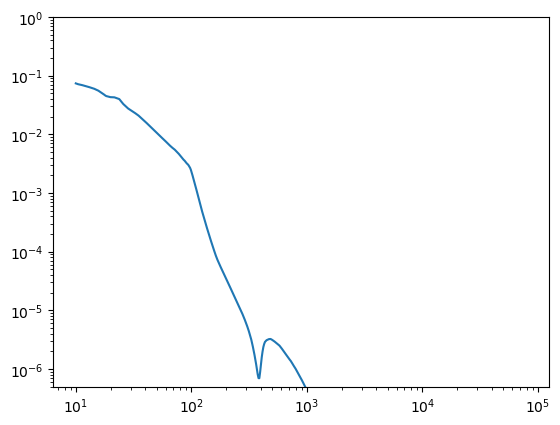

In [76]:
# plt.plot(df['E'].tolist(), df['R'].tolist())
plt.plot(df['E'].tolist(), df['newR'].tolist())
x = np.linspace(30000, 80000, 300)
a = df.loc[lastpoint,'E']**4*df.loc[lastpoint,'newR']
plt.plot(x,x**(-4)*a)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([10, 30000])
plt.ylim([5e-7, 1])
plt.show()

In [46]:
import numpy as np
import matplotlib.pyplot as plt



plt.show()

In [ ]:
웹용 GUI 찾아보기. 